<a href="https://colab.research.google.com/github/ashley-m/VAE/blob/main/DS_6040_VAE_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.utils import img_to_array, load_img
import requests
from PIL import Image
from io import BytesIO

# Dummy Data

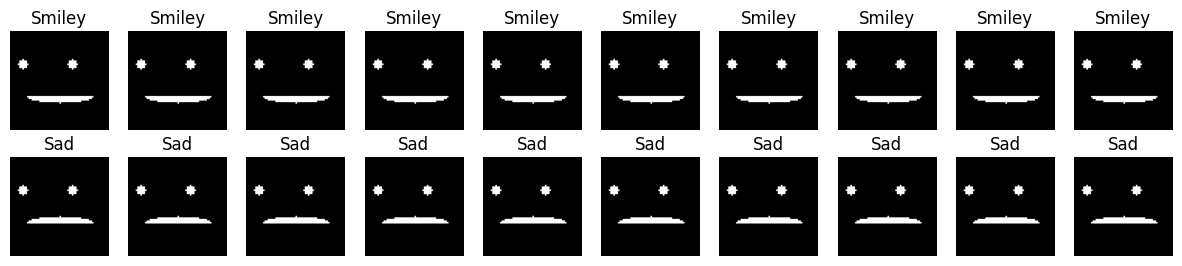

In [3]:
def create_face(height, width, is_smiley=True):
    """Create an image with a smiley or sad face."""
    image = np.zeros((height, width))
    # Parameters for eyes
    eye_distance = width // 4  # Distance between the eyes
    eyex, eyey = height // 3, width // 2 - eye_distance // 2
    eye_radius = width // 20

    # Draw eyes
    for dx in (-1, 1):
        center_x = eyex
        center_y = eyey + dx * eye_distance
        xx, yy = np.ogrid[-center_x:height-center_x, -center_y:width-center_y]
        eye_mask = (xx**2 + yy**2 <= eye_radius**2)
        image[eye_mask] = 1

    # Parameters for mouth
    mouth_width = width // 3
    mouth_height = height // 15
    mouthx, mouthy = 2 * height // 3, width // 2

    # Create a grid for the mouth
    xx, yy = np.ogrid[-mouthx:height-mouthx, -mouthy:width-mouthy]
    mouth_mask = (
        (xx**2 / mouth_height**2 + yy**2 / mouth_width**2 <= 1) &  # Elliptical mask
        (xx >= 0 if is_smiley else xx <= 0)  # Upward for smiley, downward for sad
    )
    image[mouth_mask] = 1

    return image

# Generating the dataset
height, width = 64, 64
num_images = 50  # 50 smiley and 50 sad faces
dataset_smiley = np.array([create_face(height, width, is_smiley=True) for _ in range(num_images)])
dataset_sad = np.array([create_face(height, width, is_smiley=False) for _ in range(num_images)])
dataset = np.concatenate([dataset_smiley, dataset_sad])

# Adding channel dimension for neural network compatibility
dataset = np.expand_dims(dataset, -1)

# Visualize some of the data
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0, i].imshow(dataset_smiley[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title('Smiley')
    axs[1, i].imshow(dataset_sad[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[1, i].set_title('Sad')
plt.show()

In [4]:
# dataset = np.random.shuffle(dataset)

# Standard Autoencoder

In [5]:
def build_autoencoder(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(128, activation='relu')(x)
    encoded = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(encoded)
    x = layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoder_output = layers.Reshape(input_shape)(x)
    autoencoder = models.Model(encoder_input, decoder_output)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

autoencoder = build_autoencoder((height, width, 1))
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,061,152 (4.05 MB)

 Trainable params: 1,061,152 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

# Variational Autoencoder

In [6]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_shape):
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(32)(x)
    z_log_var = layers.Dense(32)(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = models.Model(encoder_input, [z_mean, z_log_var, z])
    decoder_input = layers.Input(shape=(32,))
    x = layers.Dense(128, activation='relu')(decoder_input)
    x = layers.Dense(np.prod(input_shape), activation='sigmoid')(x)
    decoder_output = layers.Reshape(input_shape)(x)
    decoder = models.Model(decoder_input, decoder_output)
    class VAE(models.Model):
        def __init__(self, encoder, decoder, **kwargs):
            super(VAE, self).__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
        def call(self, inputs):
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstructed = self.decoder(z)
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return reconstructed
    vae = VAE(encoder, decoder)
    vae.compile(optimizer='adam', loss='binary_crossentropy')
    return vae

vae = build_vae((height, width, 1))
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)            │ [(None, 32), (None, 32),    │         532,672 │
│                                      │ (None, 32)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 64, 64, 1)           │         532,608 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,065,280 (4.06 MB)

 Trainable params: 1,065,280 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [7]:
# Training
autoencoder.fit(dataset, dataset, epochs=150, batch_size=1)
vae.fit(dataset, dataset, epochs=150, batch_size=1)

Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2762
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6136e-04
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.1315e-05
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.6990e-06
Epoch 5/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.0086e-06
Epoch 6/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.3205e-06
Epoch 7/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.6611e-07
Epoch 8/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7.5457e-07
Epoch 9/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1476e-07
Epoch 10/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.1774e-07
Epoch 11/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.4667e-07
Epoch 12/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9259e-07
Epoch 13/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5054e-07
Epoch 14/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


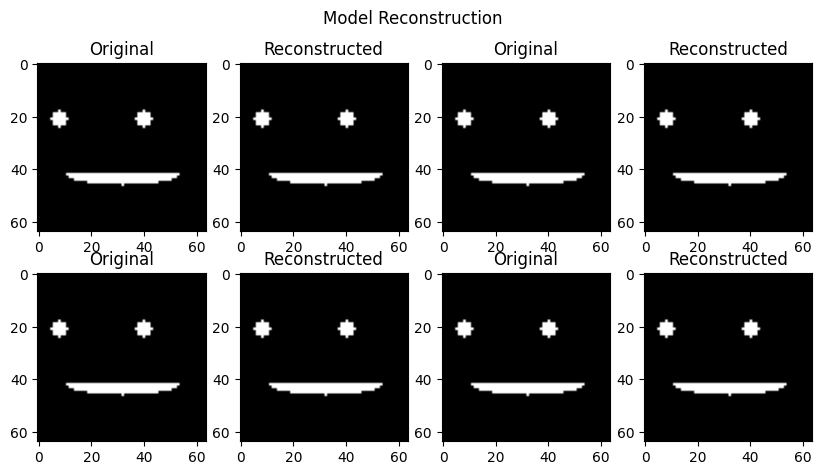

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


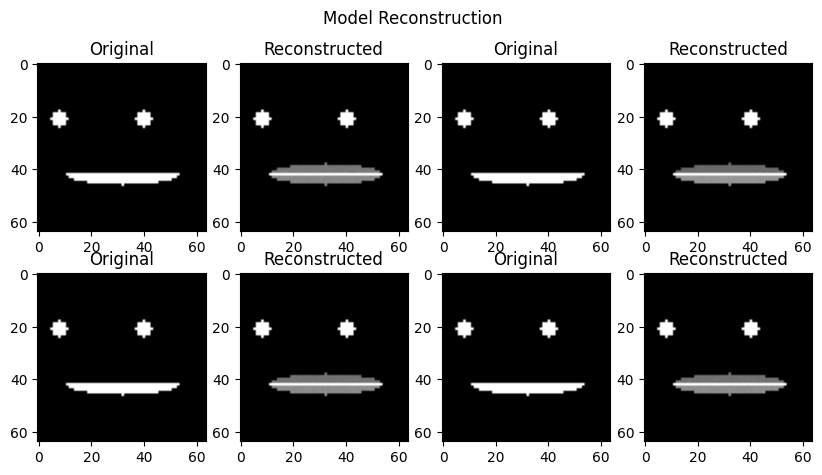

In [8]:
# Visualization of Reconstruction
def visualize_reconstruction(model, data, title="Model Reconstruction"):
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))
    for i, ax in enumerate(axs.flatten()):
        if i >= len(data):
            ax.axis('off')
            continue
        reconstructed = model.predict(np.expand_dims(data[i], 0))
        if i % 2 == 0:
            ax.imshow(data[i].squeeze(), cmap='gray')
            ax.title.set_text("Original")
        else:
            ax.imshow(reconstructed.squeeze(), cmap='gray')
            ax.title.set_text("Reconstructed")
    plt.suptitle(title)
    plt.show()

visualize_reconstruction(autoencoder, dataset)
visualize_reconstruction(vae, dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


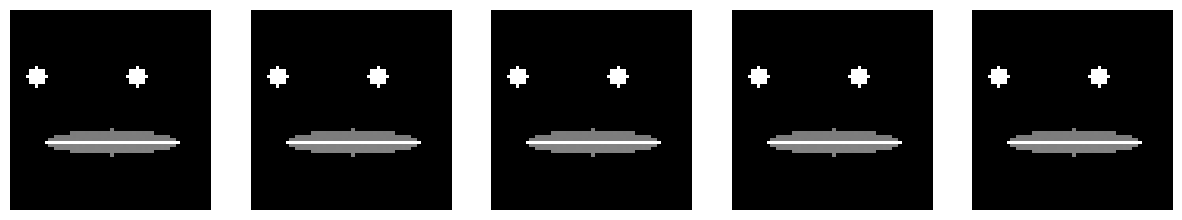

In [9]:
# Interpolation in latent space
def interpolate_points(model, data, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    z_mean, _, _ = model.encoder.predict(data[:2])
    for i, alpha in enumerate(np.linspace(0, 1, n)):
        z_interpolated = z_mean[0] * (1 - alpha) + z_mean[1] * alpha
        sample = model.decoder.predict(np.array([z_interpolated]))
        axs[i].imshow(sample.squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

interpolate_points(vae, dataset)